# Prepared for Stripe

Code example prepared for Stripe by John J Vickers on February 13, 2021, 
a rainy Saturday in the year of the Ox.

This code shows a simple signal extraction from a background where the common
KS test will fail. Instead of comparing CDFs, it compares the derivatives of 
the CDFs.

This is a cute little trick I saw someone else use to find embedded structures in data sets, and I thought I'd share.

In [1]:
import random as rnd
import pylab as pl
import numpy as np

from scipy.stats import ks_2samp
from scipy.interpolate import interp1d

In [2]:
# window = window-size (_in y_) for determining the slope
# mc_count = bootstrap count for determining error regions
window = 75
mc_count = 100

rnd.seed(a=983247)

# make data
# bg = background parameters
bg_mean, bg_std, bg_n = 0, 20, 1000
# sig = signal parameters
sig_mean, sig_std, sig_n = 10, 3, 75

d_bg = [rnd.normalvariate(bg_mean, bg_std) for i in range(bg_n)]

d_bg_2 = [rnd.normalvariate(bg_mean, bg_std) for i in range(bg_n)]
d_sig = [rnd.normalvariate(sig_mean, sig_std) for i in range(sig_n)]
d_co = d_bg_2+d_sig

d_bg = sorted(d_bg)
d_co = sorted(d_co)

# Look, Ma, no signal!

KstestResult(statistic=0.047232558139534885, pvalue=0.18997283367833262)


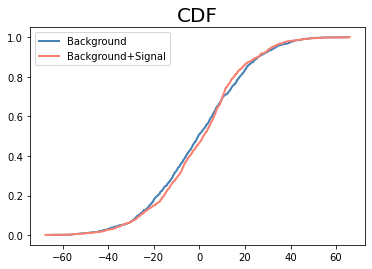

In [3]:
'''
Plot cumulative distribution functions for each population

Since the bulk of each sample are from the same underlying distribution, there
will be no obvious difference between them, and the KS test will fail.
'''

y = [a / len(d_bg) for a in range(1, len(d_bg)+1)]
pl.plot(d_bg, y, lw=2, color='steelblue', label='Background')

y = [a / len(d_co) for a in range(1, len(d_co)+1)]
pl.plot(d_co, y, lw=2, color='salmon', label='Background+Signal')

pl.legend()
pl.title('CDF', fontsize=20)

# KS test fails for this since the are from the same population, globally
print(ks_2samp(d_bg, d_co))

# It's a bird, it's a plane!

(0.0, 35.0)

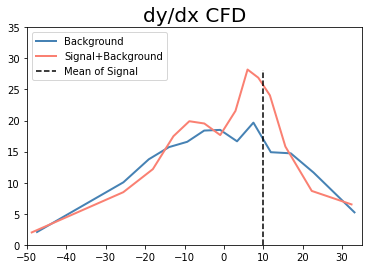

In [4]:
'''
I'm calculating the slope of the CDF.

Since we're working with discrete counts which are uneven in x but even in y,
we can just say 'dy = n', and then dx is just the difference betwixt every 
nth point

So if we have [1, 2, 3, 5, 7, 8, 8], and our n is 2, the slopes are:
[2/(3-1)], [2/(7-3)], [2/(8-7)] = [1, 0.5, 2]

It's just a quick and dirty way to do this
'''


xt = d_bg[::window]
xplot = [(a+b)/2 for a,b in zip(xt[1:], xt[:-1])]
dydx = [window / (a-b) for a, b in zip(xt[1:], xt[:-1])]
pl.plot(xplot, dydx, lw=2, color='steelblue', label='Background')


xt = d_co[::window]
xplot = [(a+b)/2 for a,b in zip(xt[1:], xt[:-1])]
dydx = [window / (a-b) for a, b in zip(xt[1:], xt[:-1])]
pl.plot(xplot, dydx, lw=2, color='salmon', label='Signal+Background')


pl.plot([sig_mean, sig_mean], [0, max(dydx)], c='k', ls='--', 
        label='Mean of Signal')

pl.legend()
pl.title('dy/dx CFD', fontsize=20)

pl.xlim(-50, 35)
pl.ylim(0, 35)

# Get a proper job.

Text(0.5, 1.0, 'dy/dx CFD')

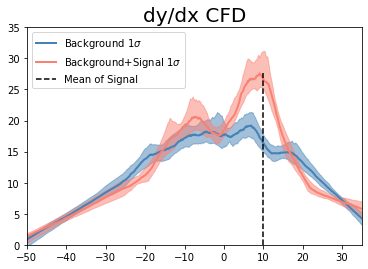

In [5]:
'''
So now we'll just do a proper job, find the confidence intervals to see if the 
signal is significant or not

For mc_count iterations we will
1) create a bootstrapped sample (with repeats)
2) find the dydx(x) for the sample
3) put the dydx(x) values in a list yplots

Then we will
1) find the range of dydx(x) values at each x, and plot the 68% C.I.s
'''

min_xplot = min([min(d_bg[1:-1]), min(d_co[1:-1])])
max_xplot = max([max(d_bg[1:-1]), max(d_co[1:-1])])
xplot = np.linspace(min_xplot, max_xplot, 1000)

def get_error_volume(du):

    yplots = []
    # We'll just pull ourselves up by our bootstraps here 
    for i in range(mc_count):
        
        # dt = [len(du) random values from du]
        dt = [du[rnd.randint(0, len(du)-1)] for i in range(len(du))]
        xt = sorted(dt)[::window]
        xa = [(a+b)/2 for a,b in zip(xt[1:], xt[:-1])]
        dydx = [window / (a-b) for a, b in zip(xt[1:], xt[:-1])]

        # yeah, so this is going to be bogus on the edges (bounds_err, fill_val)
        func = interp1d(xa, dydx, bounds_error=False, fill_value='extrapolate')
        yplots.append(func(xplot))


    # yplots is mc_count sets of dydx values, evenly spaced in x
    # if we transpose it, we have all the dydx values at a given x
    # then we can sort the dydx values at each x, and get the 68% C.I.
    yplots = list(np.array(yplots).T)
    yplot_md = [sorted(a)[int(0.5*len(a))] for a in yplots]
    yplot_hi = [sorted(a)[int(0.84*len(a))] for a in yplots]
    yplot_lo = [sorted(a)[int(0.16*len(a))] for a in yplots]

    return(yplot_md, yplot_hi, yplot_lo)


yplot_md, yplot_hi, yplot_lo = get_error_volume(d_bg)
pl.plot(xplot, yplot_md, lw=2, color='steelblue', 
        label='Background 1$\sigma$')
pl.fill_between(xplot, yplot_hi, yplot_lo, color='steelblue', alpha=0.5)

yplot_md, yplot_hi, yplot_lo = get_error_volume(d_co)
pl.plot(xplot, yplot_md, lw=2, color='salmon', 
        label='Background+Signal 1$\sigma$')
pl.fill_between(xplot, yplot_hi, yplot_lo, color='salmon', alpha=0.5)

pl.plot([sig_mean, sig_mean], [0, max(yplot_md)], c='k', ls='--', 
        label='Mean of Signal')

pl.xlim(-50, 35)
pl.ylim(0, 35)

pl.legend(loc='upper left')
pl.title('dy/dx CFD', fontsize=20)